In [3]:
# let us first import the libraries
# local import for convinience
import sys, os
sys.path.insert(1, '../src/SupplyNetPy/Components/')
import core as scm
import utilities as scm

import numpy as np
import matplotlib.pyplot as plt

def print_performance_metrics(supplychainnet):
    for key, value in supplychainnet.items():
        print(f"{key}: {value}")

INFO d1 - 2.0000:d1:Customer1:Order quantity:1 received.
INFO d1 - 2.0000:d1:Customer21: Order quantity:1 not available, inventory level:0. No tolerance! Shortage:1.
INFO d1 - 2.1000:d1:Customer2:Order quantity:1 received.
INFO d1 - 2.1000:d1:Customer22: Order quantity:1 not available, inventory level:0. No tolerance! Shortage:1.
INFO d1 - 2.2000:d1:Customer3:Order quantity:1 received.
INFO d1 - 2.2000:d1:Customer23: Order quantity:1 not available, inventory level:0. No tolerance! Shortage:1.
INFO d1 - 2.3000:d1:Customer4:Order quantity:1 received.
INFO d1 - 2.3000:d1:Customer24: Order quantity:1 not available, inventory level:0. No tolerance! Shortage:1.
INFO d1 - 2.4000:d1:Customer5:Order quantity:1 received.
INFO d1 - 2.4000:d1:Customer25: Order quantity:1 not available, inventory level:0. No tolerance! Shortage:1.
INFO d1 - 2.5000:d1:Customer6:Order quantity:1 received.
INFO d1 - 2.5000:d1:Customer26: Order quantity:1 not available, inventory level:0. No tolerance! Shortage:1.
INFO

nodes: {'S1': Supplier 1, 'D1': Distributor1}
links: {'L1': S1 to D1}
demands: {'d1': Demand1}
env: <simpy.core.Environment object at 0x000001BDD8833750>
num_of_nodes: 2
num_of_links: 1
num_suppliers: 1
num_manufacturers: 0
num_distributors: 1
num_retailers: 0
total_available_inv: 4
avg_available_inv: 2.0
total_inv_carry_cost: 1.1999999999999986
total_inv_spend: 500
total_transport_cost: 190
total_revenue: 1600
total_cost: 691.2
total_profit: 908.8
total_demand_by_customers: [51, 51]
total_fulfillment_received_by_customers: [10, 10]
total_demand_by_site: [3, 15]
total_fulfillment_received_by_site: [2, 10]
total_demand: [54, 66]
total_fulfillment_received: [12, 20]
total_shortage: [35, 35]
total_backorders: [0, 0]
avg_cost_per_order: 12.8
avg_cost_per_item: 10.472727272727273


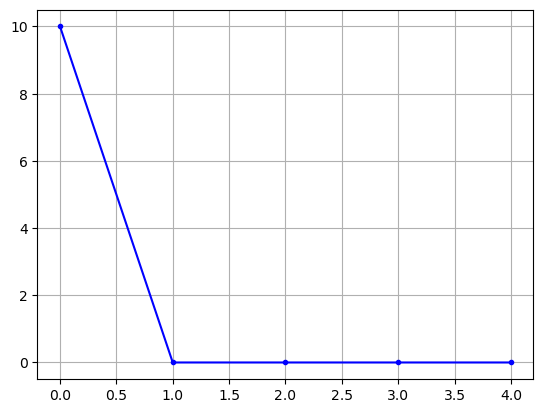

In [6]:
"""
Testing replenishment policies with a simple supply chain network
"""

import simpy
env = simpy.Environment()
supplier = scm.Supplier(env=env, ID='S1', name='Supplier 1', node_type='infinite_supplier',logging=False)
distributor = scm.InventoryNode(env=env, ID='D1', name='Distributor1', node_type='distributor', capacity=11, initial_level=10, 
                                inventory_holding_cost=0.2, replenishment_policy=scm.RQReplenishment, policy_param={'R':5,'Q':5}, 
                                product_sell_price=100, product_buy_price=50)
link1  = scm.Link(env=env, ID='L1', source=supplier, sink=distributor, cost=10, lead_time=lambda: 4)
demand1 = scm.Demand(env=env, ID='d1', name='Demand1', order_arrival_model=lambda: 0.1, order_quantity_model=lambda:1, logging=True,
                     demand_node=distributor, delivery_cost=lambda: 10, lead_time=lambda: 2)#, order_min_split_ratio=0.5, tolerance=float('inf'))
#demand2 = scm.Demand(env=env, ID='demand_2', name='Dem 2', order_arrival_model=lambda: 2, order_quantity_model=lambda:120, 
#                     demand_node=distributor, delivery_cost=lambda: 10, lead_time=lambda: 2)
scm.global_logger.enable_logging()
supplynet = scm.create_sc_net(env=env,nodes=[supplier,distributor],links=[link1],demands=[demand1])
supplynet = scm.simulate_sc_net(supplynet, sim_time=5, logging=(2,3))
print_performance_metrics(supplynet)

inv_levels = np.array(distributor.inventory.instantaneous_levels)
plt.plot(inv_levels[:,0], inv_levels[:,1], label='Inventory Level at D1', marker='.', color='blue')
plt.grid()

INFO D1 - 0.0000:D1: Inventory levels:10, on hand:10
INFO d2 - 0.0000:d2:Customer1:Order quantity:1, available.
INFO D1 - 1.0000:D1: Inventory levels:9, on hand:9
INFO d2 - 1.0000:d2:Customer2:Order quantity:1, available.
INFO d2 - 2.0000:d2:Customer1:Order quantity:1 received.
INFO D1 - 2.0000:D1: Inventory levels:8, on hand:8
INFO d2 - 2.0000:d2:Customer3:Order quantity:1, available.
INFO d2 - 3.0000:d2:Customer2:Order quantity:1 received.
INFO D1 - 3.0000:D1: Inventory levels:7, on hand:7
INFO d2 - 3.0000:d2:Customer4:Order quantity:1, available.
INFO d2 - 4.0000:d2:Customer3:Order quantity:1 received.
INFO D1 - 4.0000:D1: Inventory levels:6, on hand:6
INFO d2 - 4.0000:d2:Customer5:Order quantity:1, available.
INFO d2 - 5.0000:d2:Customer4:Order quantity:1 received.
INFO D1 - 5.0000:D1: Inventory levels:5, on hand:5
INFO D1 - 5.0000:D1:Replenishing inventory from supplier:Factory1, order placed for 10 units.
INFO d2 - 5.0000:d2:Customer6:Order quantity:1, available.
INFO d2 - 6.0000

nodes: {'S1': Supplier1, 'F1': Factory1, 'D1': Distributor1}
links: {'L1': S1 to F1}
demands: {'d2': Demand2}
env: <simpy.core.Environment object at 0x000002C4530C71D0>
num_of_nodes: 3
num_of_links: 1
num_suppliers: 1
num_manufacturers: 1
num_distributors: 1
num_retailers: 0
total_available_inv: 815.0
avg_available_inv: 372.61290322580646
total_inv_carry_cost: 357.9
total_inv_spend: 444
total_transport_cost: 240
total_revenue: 2134
total_cost: 1411.9
total_profit: 722.0999999999999
total_demand_by_customers: [31, 31]
total_fulfillment_received_by_customers: [20, 20]
total_demand_by_site: [5, 114]
total_fulfillment_received_by_site: [4, 104]
total_demand: [36, 145]
total_fulfillment_received: [24, 124]
total_shortage: [14, 37.0]
total_backorders: [3, 35]
avg_cost_per_order: 39.21944444444445
avg_cost_per_item: 9.737241379310346


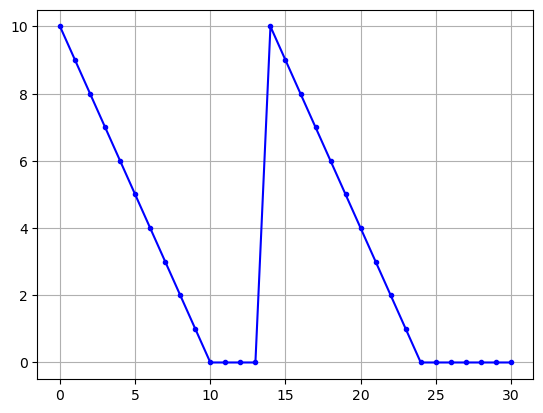

In [3]:
"""
Testing for bugs and errors
"""

import simpy
env = simpy.Environment()
raw_mat = scm.RawMaterial(ID="rm1", name="raw1", extraction_quantity=30, extraction_time=1, mining_cost=0.1,cost=1)
supplier = scm.Supplier(env=env, ID='S1', name='Supplier1', node_type='supplier',capacity=2000,inventory_holding_cost=0.02,
                        raw_material=raw_mat,logging=False)
product = scm.Product(ID='P1', name='Product1', manufacturing_cost=20, manufacturing_time=1,sell_price=50,
                      raw_materials = [(raw_mat,1)], batch_size=1)
factory = scm.Manufacturer(env=env, ID='F1', name='Factory1', capacity=20, initial_level=5, inventory_holding_cost=0.1,
                           product_sell_price=50, replenishment_policy=scm.SSReplenishment, policy_param={'s':5,'S':20},
                           product =product, logging=False)
distributor = scm.InventoryNode(env=env, ID='D1', name='Distributor1', node_type='distributor', capacity=15, initial_level=10, 
                                inventory_holding_cost=1, replenishment_policy=scm.SSReplenishment, logging=True,
                                policy_param={'s':5,'S':15,'period':1}, 
                                product_sell_price=52, product_buy_price=35)
link1 = scm.Link(env=env, ID='L1', source=supplier, sink=factory, cost=10, lead_time=lambda: 2)
link2 = scm.Link(env=env, ID='L2', source=factory, sink=distributor, cost=5, lead_time=lambda: 1)
demand2 = scm.Demand(env=env, ID='d2', name='Demand2', order_arrival_model=lambda: 1, order_quantity_model=lambda:1, 
                     demand_node=distributor, delivery_cost=lambda: 10, lead_time=lambda: 2, logging=True)

scm.global_logger.enable_logging()
import numpy as np
import matplotlib.pyplot as plt
supplynet = scm.create_sc_net(env=env,nodes=[supplier,factory,distributor],links=[link1],demands=[demand2])
supplynet = scm.simulate_sc_net(supplynet, sim_time=31)
inv_levels = np.array(distributor.inventory.instantaneous_levels)
plt.plot(inv_levels[:,0], inv_levels[:,1], label='Inventory Level at D1', marker='.', color='blue')
plt.grid()
print_performance_metrics(supplynet)

INFO D1 - 0.0000:D1: Inventory levels:500, on hand:500
INFO D1 - 0.0000:D1: Inventory levels:300, on hand:300
INFO D1 - 2.0000:D1: Inventory levels:100, on hand:100
INFO D1 - 2.0000:D1:Replenishing inventory from supplier:Supplier 1, order placed for 400 units.
INFO D1 - 2.0000:D1:shipment in transit from supplier:Supplier 1.
INFO D1 - 4.0000:D1: Inventory levels:20, on hand:420
INFO D1 - 5.0000:D1:Inventory replenished. reorder_quantity=400, Inventory levels:420
INFO D1 - 6.0000:D1: Inventory levels:220, on hand:220
INFO D1 - 8.0000:D1: Inventory levels:20, on hand:20
INFO D1 - 8.0000:D1:Replenishing inventory from supplier:Supplier 1, order placed for 480 units.
INFO D1 - 8.0000:D1:shipment in transit from supplier:Supplier 1.
INFO sim_trace - Supply chain performance measures:
INFO sim_trace - nodes: {'S1': Supplier 1, 'S2': Supplier 2, 'S3': Supplier 3, 'D1': Distributor 1}
INFO sim_trace - links: {'L1': S1 to D1, 'L2': S2 to D1, 'L3': S3 to D1}
INFO sim_trace - demands: {'d1': Dem

INFO sim_trace - total_cost: 80454.0
INFO sim_trace - total_profit: 139546.0
INFO sim_trace - total_demand_by_customers: [10, 1000]
INFO sim_trace - total_fulfillment_received_by_customers: [9, 880]
INFO sim_trace - total_demand_by_site: [2, 880]
INFO sim_trace - total_fulfillment_received_by_site: [1, 400]
INFO sim_trace - total_demand: [12, 1880]
INFO sim_trace - total_fulfillment_received: [10, 1280]
INFO sim_trace - total_shortage: [1, 100]
INFO sim_trace - total_backorders: [0, 0]
INFO sim_trace - avg_cost_per_order: 6704.5
INFO sim_trace - avg_cost_per_item: 42.79468085106383


nodes: {'S1': Supplier 1, 'S2': Supplier 2, 'S3': Supplier 3, 'D1': Distributor 1}
links: {'L1': S1 to D1, 'L2': S2 to D1, 'L3': S3 to D1}
demands: {'d1': Demand 1, 'd2': Demand 2}
env: <simpy.core.Environment object at 0x000002C4531F1490>
num_of_nodes: 4
num_of_links: 3
num_suppliers: 3
num_manufacturers: 0
num_distributors: 1
num_retailers: 0
total_available_inv: 20
avg_available_inv: 192.0
total_inv_carry_cost: 344.0
total_inv_spend: 80000
total_transport_cost: 110
total_revenue: 220000
total_cost: 80454.0
total_profit: 139546.0
total_demand_by_customers: [10, 1000]
total_fulfillment_received_by_customers: [9, 880]
total_demand_by_site: [2, 880]
total_fulfillment_received_by_site: [1, 400]
total_demand: [12, 1880]
total_fulfillment_received: [10, 1280]
total_shortage: [1, 100]
total_backorders: [0, 0]
avg_cost_per_order: 6704.5
avg_cost_per_item: 42.79468085106383


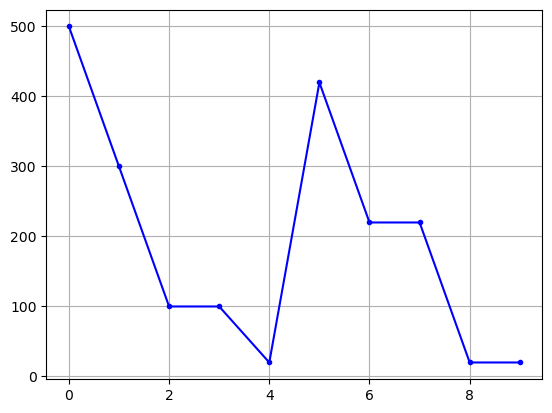

In [4]:
"""
Testing supplier selection policies with multiple suppliers
"""

import simpy
env = simpy.Environment()
supplier = scm.Supplier(env=env, ID='S1', name='Supplier 1', node_type='infinite_supplier',logging=False)
supplier2 = scm.Supplier(env=env, ID='S2', name='Supplier 2', node_type='infinite_supplier',logging=False)
supplier3 = scm.Supplier(env=env, ID='S3', name='Supplier 3', node_type='infinite_supplier',logging=False)
distributor = scm.InventoryNode(env=env, ID='D1', name='Distributor 1', node_type='distributor', capacity=500, initial_level=500, 
                                inventory_holding_cost=0.2, replenishment_policy=scm.SSReplenishment, policy_param={'s':200,'S':500}, 
                                product_sell_price=250, product_buy_price=200, supplier_selection_policy=scm.SelectFirst)
link1  = scm.Link(env=env, ID='L1', source=supplier, sink=distributor, cost=10, lead_time=lambda: 3)
link2  = scm.Link(env=env, ID='L2', source=supplier2, sink=distributor, cost=20, lead_time=lambda: 2)
link3  = scm.Link(env=env, ID='L3', source=supplier3, sink=distributor, cost=30, lead_time=lambda: 1)
demand1 = scm.Demand(env=env, ID='d1', name='Demand 1', order_arrival_model=lambda: 2, order_quantity_model=lambda:80, 
                     demand_node=distributor, delivery_cost=lambda: 10, lead_time=lambda: 1,logging=False)
demand2 = scm.Demand(env=env, ID='d2', name='Demand 2', order_arrival_model=lambda: 2, order_quantity_model=lambda:120, 
                     demand_node=distributor, delivery_cost=lambda: 10, lead_time=lambda: 1,logging=False)
scm.global_logger.enable_logging()

import numpy as np
import matplotlib.pyplot as plt
supplynet = scm.create_sc_net(env=env, nodes=[supplier, supplier2, supplier3, distributor],links=[link1, link2, link3],demands=[demand1,demand2])
supplynet = scm.simulate_sc_net(supplynet, sim_time=10)
inv_levels = np.array(distributor.inventory.instantaneous_levels)
plt.plot(inv_levels[:,0], inv_levels[:,1], label='Inventory Level at D1', marker='.', color='blue')
plt.grid()
print_performance_metrics(supplynet)